# AB Testing Practice - Hai Vu

## Project Overview:
- Data set taken from Kaggle: https://www.kaggle.com/datasets/zhangluyuan/ab-testing
- Show customers' conversion (whether customers complete a purchase when visiting the web page) after interacting with either the old or the new version of a landing page
- Conduct AB test to see if the new landing page improves conversion rates

## Table of Contents:
<a id='TOC'></a>
- [I. Data Cleaning](#cleaning)
- [II. Test Method 1](#test1)
- [III. Test Method 2](#test2)
- [IV. Code References](#ref)

In [30]:
# Import libraries
import numpy as np
import pandas as pd
import pingouin as pg
import statsmodels.stats.api as sms
from scipy.stats import shapiro, levene, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from math import ceil

## I. Data Cleaning:
<a id='cleaning'></a>

In [31]:
# Import data set
df_data = pd.read_csv("ab_data.csv")

In [32]:
# Overview of data
df_data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [33]:
# Info of variables
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [34]:
# Convert timestamp to date time
df_data['timestamp'] = pd.to_datetime(df_data['timestamp'])
df_data['full_date'] = pd.to_datetime(df_data['timestamp'].dt.strftime('%Y-%m-%d'))
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
 5   full_date     294478 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 13.5+ MB


In [35]:
# Show time range
print(min(df_data['timestamp']))
print(max(df_data['timestamp']))

2017-01-02 13:42:05.378582
2017-01-24 13:41:54.460509


In [36]:
# Count of group by landing page
df_data.groupby(['group','landing_page']).size().reset_index(name='count')

,group,landing_page,count
0,control,new_page,1928
1,control,old_page,145274
2,treatment,new_page,145311
3,treatment,old_page,1965


In [37]:
# Check null values
df_data.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
full_date       0
dtype: int64

In [38]:
# Check unique values count
df_data.apply(lambda x: x.nunique())

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
full_date           23
dtype: int64

In [39]:
# Show number of duplicates
print(df_data.duplicated(subset= ['user_id']).sum())
print(df_data.shape)

# Remove duplicates
df_data2 = df_data.drop_duplicates(subset= ['user_id'], keep = 'first')
df_data2.shape

3894
(294478, 6)


(290584, 6)

In [40]:
# Count of groups by landing page (after removing duplicates)
df_data2.groupby(['group','landing_page']).size().reset_index(name='count')

,group,landing_page,count
0,control,new_page,1006
1,control,old_page,144226
2,treatment,new_page,144314
3,treatment,old_page,1038


In [41]:
# Only consider 2 groups: control = old_page, treatment = new_page
df_data2 = df_data2[((df_data2['group'] == 'control') & (df_data2['landing_page'] == 'old_page')) | 
                    ((df_data2['group'] == 'treatment') & (df_data2['landing_page'] == 'new_page'))]

In [42]:
# New distribution of groups by page
df_data2.groupby(['group','landing_page']).size().reset_index(name='count')

,group,landing_page,count
0,control,old_page,144226
1,treatment,new_page,144314


In [43]:
# Show more info on conversion
conversion_rates = df_data2.groupby('group')['converted'].agg([np.mean, np.median, np.std, stats.sem]).reset_index()
conversion_rates.columns = ['group', 'mean_conversion_rate', 'median_conversion_rate', 'std_deviation', 'std_error']
conversion_rates

,group,mean_conversion_rate,median_conversion_rate,std_deviation,std_error
0,control,0.120290,0.0,0.325302,0.000857
1,treatment,0.118727,0.0,0.323468,0.000851


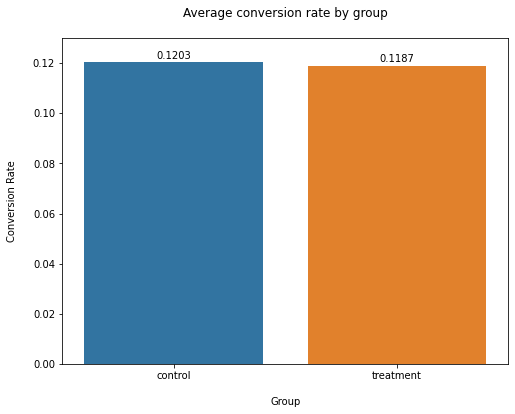

In [83]:
# Barplot of conversion rate
plt.figure(figsize=(8,6))
ax = sns.barplot(x=df_data2['group'], y=df_data2['converted'], ci=False)

plt.ylim(0, 0.13)
plt.title('Average conversion rate by group\n')
plt.xlabel('\nGroup')
plt.ylabel('Conversion Rate\n')
ax.bar_label(ax.containers[0], labels=round(df_data2.groupby('group')['converted'].mean(),4), padding=2)

plt.show()

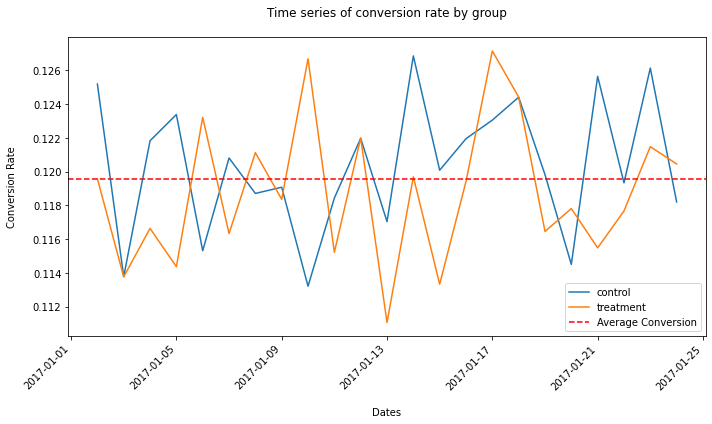

In [89]:
# Create time series plot for conversion rate by group
df_series = df_data2.groupby(['full_date','group'])['converted'].agg([np.mean, np.sum, np.size]).reset_index()

plt.figure(figsize=(10,6))
for i in df_series['group'].unique():
    df_group = df_series[df_series['group'] == i]
    plt.plot(df_group['full_date'], df_group['mean'], label=i)

plt.axhline(y=np.nanmean(df_series['mean']), linestyle='dashed', color='red', label='Average Conversion')
plt.legend(loc="lower right")
plt.title('Time series of conversion rate by group\n')
plt.xlabel('\nDates')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Conversion Rate\n')

plt.tight_layout()
plt.show()

## II. Test Method 1:
<a id='test1'></a>

Check normality assumption using the normality test from the scipy library (based on D’Agostino and Pearson’s test that combines skew and kurtosis to produce an omnibus test of normality). <b><u>[Read more about it here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html)</u></b>:
- H0: The assumption of normal distribution is provided
- H1: The assumption of normal distribution is not provided

Assuming that our alpha is 0.05, if the p-value is less than 0.05, we reject the null hypothesis and a non-parametric test (Mann-Whitney U test) will be used. If not, we will use a parametric test (t-test or z-test)

In [70]:
test_stat_old, pvalue_old = stats.normaltest(df_data2[df_data2['landing_page'] == 'old_page']['converted'])
print("p-value of control group:", pvalue_old)
print("test_stat of control group:", test_stat_old)

p-value of control group: 0.0
test_stat of control group: 62118.728404598005


In [72]:
test_stat_new, pvalue_new = stats.normaltest(df_data2[df_data2['landing_page'] == 'new_page']['converted'])
print("p-value of treatment group:", pvalue_new)
print("test_stat of treatment group:", test_stat_new)

p-value of treatment group: 0.0
test_stat of treatment group: 63026.74538156684


In this case, the p-values from both tests are less than 0.05, thus, we can reject the null hypothesis and conclude that the assumption of normal distribution is not provided. We will be using the Mann-Whitney U test to conduct our AB test. 

The Mann-Whitney U test (a.k.a. the Mann Whitney Wilcoxon Test or the Wilcoxon Rank Sum Test) is used to test whether two samples are likely to derive from the same population (i.e., that the two populations have the same shape). Some investigators interpret this test as comparing the medians between the two samples, which is different from the common parametric tests that compare the means (H0: μ1=μ2) between independent groups. <b><u>[Read more about it here:](https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_nonparametric/bs704_nonparametric4.html)</u></b>

In [119]:
# Balance the sample size in each group
balance_n = min(len(df_data2[df_data2['group']=='control']), len(df_data2[df_data2['group']=='treatment']))
df_control = df_data2[(df_data2['group'] == 'control')].sample(n=balance_n, random_state =99)
df_treatment = df_data2[(df_data2['group'] == 'treatment')].sample(n=balance_n, random_state =99)

# Concat two groups
df_test = pd.concat([df_control, df_treatment], axis=0).reset_index(drop=True)
df_test.groupby(['group','landing_page']).size().reset_index(name='count')

,group,landing_page,count
0,control,old_page,144226
1,treatment,new_page,144226


Hypotheses of the non-parametric Mann-Whitney U test:
- H0: There is no statistically significant difference between the median conversion rate of the old page and the new page
- H1: There is statistically significant difference between the median conversion rate of the old page and the new page

Assuming that our alpha is 0.05, if the p-value is less than 0.05, it is considered significant and we can reject the null hypothesis

In [122]:
# Conduct Mann-Whitney U test
test_stat, pvalue = mannwhitneyu(df_test[df_test['landing_page'] == 'old_page']['converted'],
                                 df_test[df_test['landing_page'] == 'new_page']['converted'],
                                 method = 'asymptotic') # choose asymptotic for large sample size

print('Test Stat = %.1f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 10416650737.0, p-value = 0.2006


Since our p-value is greater than 0.05, we fail to reject the null hypothesis and conclude that there is no statistically significant difference between the new page and the old page. In other words, the new change does not significantly influence the conversion rate.

## III. Test Method 2:
<a id='test2'></a>

Even though we have tested that the data distribution is likely to be non-normal, we should also consider that the z-test is best used for greater-than-30 samples because under the central limit theorem, as the number of samples gets larger, the samples are considered to be approximately normally distributed. In this case, since we have a lot of data, we can try using the z-test as a second way of conducting our AB test. (Source: [Investopedia](https://www.investopedia.com/terms/z/z-test.asp))

First, we compute the required sample size for our z-test using the power analysis approach:

In [127]:
# Power analysis (if assumption of the change in conversion rate is known)
rate_old = round(float(conversion_rates[conversion_rates['group'] == 'control']['mean_conversion_rate']),3) # Mean conversion rate from control group
rate_new = rate_old + 0.02 # Test if the rates increase by 2% (assumption of change is +2%)

# Calculating effect size based on our expected rates
effect_size = sms.proportion_effectsize(rate_old, rate_new)

# Calculating sample size needed (alpha = 0.05, beta = 0.1, power = 1-beta = 0.9)
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.9, alpha=0.05, ratio=1)

# Rounding up the whole number
required_n = ceil(required_n)
print("The required sample size per group for z-test is:",required_n)

The required sample size per group for z-test is: 5934


In [125]:
# Random sampling from each group
df_control = df_data2[(df_data2['group'] == 'control')].sample(n=required_n, random_state =99)
df_treatment = df_data2[(df_data2['group'] == 'treatment')].sample(n=required_n, random_state =99)

# Concat two groups
df_test2 = pd.concat([df_control, df_treatment], axis=0).reset_index(drop=True)
df_test2.groupby(['group','landing_page']).size().reset_index(name='count')

,group,landing_page,count
0,control,old_page,5934
1,treatment,new_page,5934


The two-tailed z-test hypotheses are:
- H0: There is no significant difference between the means of the two groups being compared
- H1: There is a significant difference between the means of the two groups being compared

In [126]:
# Conduct z-test
control_results = df_test2[df_test2['group'] == 'control']['converted']
treatment_results = df_test2[df_test2['group'] == 'treatment']['converted']

successes = [control_results.sum(), treatment_results.sum()] # number of conversions
n_observe = [control_results.count(), treatment_results.count()] # total sample size

# Calculate z-statistic and p-value
z_stat, pvalue = proportions_ztest(successes, nobs=n_observe)

# Calculate confidence intervals
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=n_observe, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pvalue:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.23
p-value: 0.822
ci 95% for control group: [0.114, 0.130]
ci 95% for treatment group: [0.112, 0.129]


Sinze the p-value from the z-test is greater than our alpha of 0.05, we fail to reject the null hypothesis and conclude that there is no significant difference between the means of the two groups being compared. We can also see this by looking at the overlapping confidence intervals of the 2 groups.

Both methods seem to point to the same conclusion, which is that the new landing page does not make a significant change on the conversion rate compared to the old landing page.

## IV. Code References:
<a id='ref'></a>

Inspirations from the following projects:
- https://towardsdatascience.com/ab-testing-with-python-e5964dd66143
- https://www.kaggle.com/code/ramzanzdemir/ab-testing

[Return to Table of Contents](#TOC)